In [1]:
## Necessary packages
import tensorflow as tf
from keras.models import Model, load_model, Sequential
import keras
from keras.layers import Deconvolution2D, UpSampling2D, Dense, Conv2D, Dropout, MaxPool2D, Flatten
from keras import backend as K
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import image
import matplotlib.image as mpimg
from PIL import Image, ImageOps

Using TensorFlow backend.


Verifying that GPU is available

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7837414730284942344
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6650300497
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18039162146906789272
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


Loading in the training and testing data (not suggested if memory is very limited)

In [2]:
train_path = "C:/Users/JT/Desktop/CU Boulder/CSCI 5622/Project/Alzheimer_s Dataset/train/"
test_path = "C:/Users/JT/Desktop/CU Boulder/CSCI 5622/Project/Alzheimer_s Dataset/test/"

In [7]:
X_train = []
y_train = []
train_fnames = []

for dem_type in os.listdir(train_path):
    for file in os.listdir(os.path.join(train_path,dem_type)): #cycle through the different folders
        X_train.append(cv2.imread(train_path+dem_type+"/"+file)) #read in image file and store image
        y_train.append(dem_type)                                 #store dementia type
        train_fnames.append(train_path+dem_type+"/"+file)        #store file path
        
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
train_fnames = np.asarray(train_fnames)


Let's take a look at some of our training examples from each class of image.

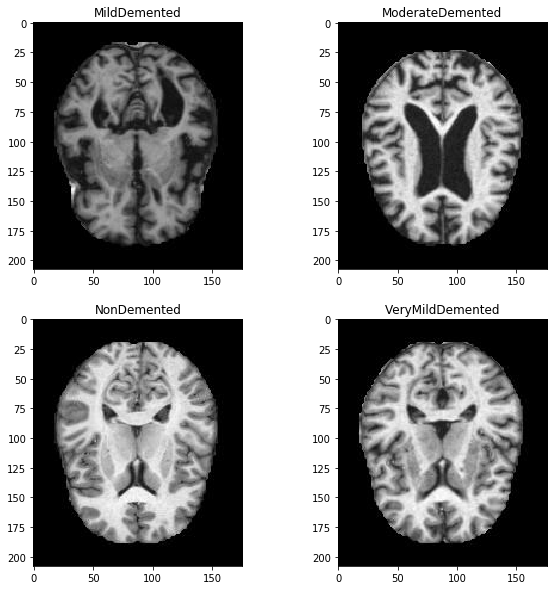

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plt.subplot(221)
plt.title(y_train[0])
plt.imshow(X_train[0]); 

plt.subplot(222)
plt.title(y_train[760])
plt.imshow(X_train[760]); 

plt.subplot(223)
plt.title(y_train[1000])
plt.imshow(X_train[1000]); 

plt.subplot(224)
plt.title(y_train[5000])
plt.imshow(X_train[5000]); 

sample_images = X_train[[0,760,1000,5000],:]
sample_labels = y_train[[0,760,1000,5000]]

Same as above except with image augmentation

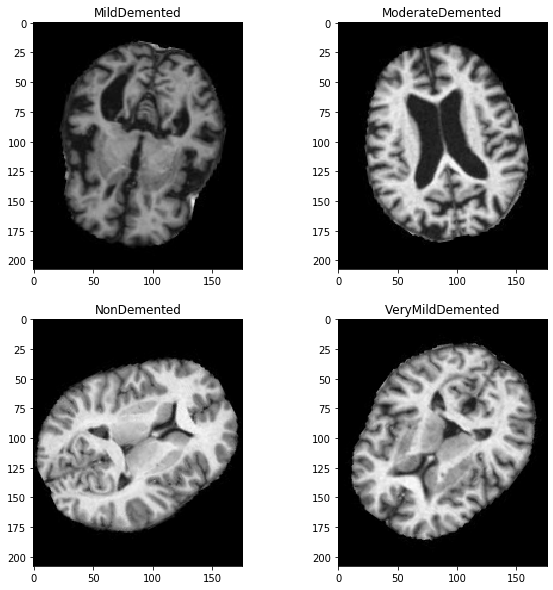

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, rotation_range=90, horizontal_flip=True, vertical_flip=True)

sample_batch = datagen.flow(sample_images, sample_labels, batch_size=4, shuffle=False)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in np.arange(4):
    plt.subplot(220+(i+1))
    plt.title(sample_batch[0][1][i]) 
    plt.imshow((sample_batch[0][0][i]*255).astype(np.uint8))
    
X_train = []
y_train = []

In [10]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
processed_dataset = datagen.flow_from_directory(
    shuffle= True,
    batch_size= 32,
    target_size= (208,176),
    directory= 'C:/Users/JT/Desktop/CU Boulder/CSCI 5622/Project/Alzheimer_s Dataset/train'
)

# datagen.fit(X_train) #machinelearningmastery.com ImageDataGenerator for more info
# datagen.fit(processed_dataset)

Found 5121 images belonging to 4 classes.


Verifying that GPU is available

In [8]:
def model():
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides = (1, 1), activation = 'relu', input_shape = (208, 176, 3)))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Conv2D(64, (3,3), strides = (1, 1), activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Conv2D(64, (3,3), strides = (1, 1), activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation = 'softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

nn = model()
nn.fit_generator(processed_dataset, steps_per_epoch = None, epochs = 15, verbose = 1)
nn.save('Model.h5')



Epoch 1/15
161/161 [==============================] - 13s 82ms/step - loss: 1.0229 - accuracy: 0.51511s - l
Epoch 2/15
161/161 [==============================] - 10s 65ms/step - loss: 0.8362 - accuracy: 0.6024
Epoch 3/15
161/161 [==============================] - 11s 65ms/step - loss: 0.6660 - accuracy: 0.6948
Epoch 4/15
161/161 [==============================] - 11s 65ms/step - loss: 0.5324 - accuracy: 0.7616
Epoch 5/15
161/161 [==============================] - 10s 64ms/step - loss: 0.4010 - accuracy: 0.8291
Epoch 6/15
161/161 [==============================] - 10s 63ms/step - loss: 0.3083 - accuracy: 0.8752
Epoch 7/15
161/161 [==============================] - 10s 63ms/step - loss: 0.2343 - accuracy: 0.9072
Epoch 8/15
161/161 [==============================] - 10s 63ms/step - loss: 0.2013 - accuracy: 0.9203
Epoch 9/15
161/161 [==============================] - 10s 64ms/step - loss: 0.1587 - accuracy: 0.9412
Epoch 10/15
161/161 [==============================] - 10s 63ms/step - los

In [11]:
nn = load_model("Model.h5")

In [13]:
nn.layers

In [14]:
def deconvModel():
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides = (1, 1), activation = 'relu', input_shape = (208, 176, 3)))#0
    model.layers[0].set_weights(nn.layers[0].get_weights())
    model.add(MaxPool2D(pool_size = (2,2)))#2
    model.add(Conv2D(64, (3,3), strides = (1, 1), activation = 'relu')) #3
    model.layers[1].set_weights(nn.layers[3].get_weights())
    model.add(MaxPool2D(pool_size = (2,2)))                      #4
    model.add(Conv2D(64, (3,3), strides = (1, 1), activation = 'relu')) #5
    model.layers[3].set_weights(nn.layers[5].get_weights())
    
    model.add(Deconvolution2D(64,3,3, output_shape = nn.layers[5].input_shape, border_mode = "valid", input_shape = nn.layers[5].output_shape))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Deconvolution2D(64,3,3, output_shape = nn.layers[3].input_shape, border_mode = "valid", input_shape = nn.layers[3].output_shape))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Deconvolution2D(64,3,3, output_shape = nn.layers[1].input_shape, border_mode = "valid", input_shape = nn.layers[1].output_shape))
    model.add(Deconvolution2D(1,3,3, output_shape = nn.layers[0].input_shape, border_mode = "valid", input_shape = nn.layers[0].output_shape))

    
    return model
deconvNN = deconvModel()

prediction = deconvNN.predict(processed_dataset[0][0])
prediction = prediction[0]

C:\Users\JT\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(64, (3, 3), input_shape=(None, 24,..., padding="valid")`
  if sys.path[0] == '':
C:\Users\JT\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(64, (3, 3), input_shape=(None, 50,..., padding="valid")`
  
C:\Users\JT\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(64, (3, 3), input_shape=(None, 103..., padding="valid")`
  app.launch_new_instance()
C:\Users\JT\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(1, (3, 3), input_shape=(None, 206..., padding="valid")`


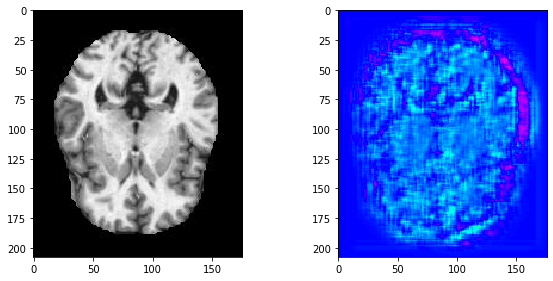

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
plt.subplot(221)
plt.imshow(processed_dataset[0][0][0]) 

######ADD SMOOTHING TO HEATMAP#####
heatmap = cv2.resize(prediction, (prediction.shape[1], prediction.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HSV) #HSV, OCEAN,
plt.subplot(222)
plt.imshow(heatmap)



############# TESTING CAM########

In [16]:
#https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

from keras.preprocessing import image
#img = image.load_img(img_path, target_size=(80, 80))
#x = image.img_to_array(img)
#x = np.expand_dims(x, axis=0)
#datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
#datagen.fit(x)
x = processed_dataset[0][0][1]
x = x.reshape(1,208,176,3)

In [ ]:
nn.layers

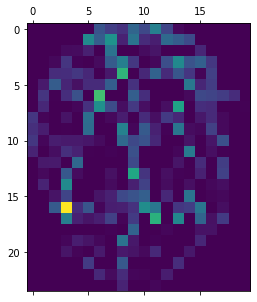

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

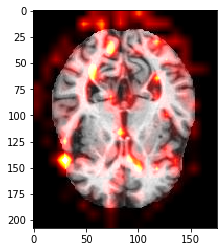

In [18]:
preds = nn.predict(x)
argmax = np.argmax(preds[0])
output = nn.output[:, argmax]
last_conv_layer = nn.layers[5]    #change to last conv layer
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([nn.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(64): #change to number of neurons
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()


img = x[0]
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_OCEAN) #HSV, OCEAN,
hif = .01
superimposed_img = heatmap * hif + img

superimposed_img = superimposed_img
plt.imshow(superimposed_img)
output = 'C:/Users/JT/Desktop/CU Boulder/CSCI 5622/Project/code_test/test.jpg'
cv2.imwrite(output, superimposed_img)


In [19]:
X_test = []
y_test = []
test_fnames = []

for dem_type in os.listdir(test_path):
    for file in os.listdir(os.path.join(test_path,dem_type)): #cycle through the different folders
        X_test.append(cv2.imread(test_path+dem_type+"/"+file)) #read in image file and store image
        y_test.append(dem_type)                                 #store WBC type
        test_fnames.append(test_path+dem_type+"/"+file)        #store file path
        
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
train_fnames = np.asarray(test_fnames)


In [20]:
datagen_test = keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
processed_dataset_test = datagen_test.flow_from_directory(
    shuffle= True,
    batch_size= 32,
    target_size= (208,176),
    directory= 'C:/Users/JT/Desktop/CU Boulder/CSCI 5622/Project/Alzheimer_s Dataset/test'
)

nn.evaluate_generator(processed_dataset_test)

Found 1279 images belonging to 4 classes.


[2.5151755809783936, 0.6278342604637146]

In [9]:
import time
preds_path = "C:/Users/JT/Desktop/CU Boulder/CSCI 5622/Project/Alzheimer_s Dataset/predictions/"

In [ ]:
last_conv_layer = nn.layers[5]
start = time.time()

for dem_type in os.listdir(train_path):
    for file in os.listdir(os.path.join(train_path,dem_type)):
       
        x = cv2.imread(train_path+dem_type+"/"+file)
        file_path = train_path+dem_type+"/"+file
    
        x = x.reshape(1,208,176,3)
        preds = nn.predict(x*1./255)
        argmax = np.argmax(preds)
        output = nn.output[:, argmax]

          #change to last conv layer
        grads = K.gradients(output, last_conv_layer.output)[0]
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
        iterate = K.function([nn.input], [pooled_grads, last_conv_layer.output[0]])
        pooled_grads_value, conv_layer_output_value = iterate([x])

        for i in range(64): #change to number of neurons
            conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

        pooled_grads_value, conv_layer_output_value = iterate([x])

        heatmap = np.mean(conv_layer_output_value, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)


        #img = x[0]
        heatmap = cv2.resize(heatmap, (x.shape[2], x.shape[1]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_OCEAN) #HSV, OCEAN,
        hif = .01
        heatmap = heatmap*hif
        
        #plt.matshow(heatmap)
        cv2.imwrite(preds_path+dem_type+"/"+file, 255*heatmap)
        

end = time.time()
print(end - start)

'''
#superimposed_img = heatmap * hif + img



#superimposed_img = superimposed_img
#plt.imshow(superimposed_img)
'''



In [10]:
X_pred = []
y_pred = []

for dem_type in os.listdir(preds_path):
    for file in os.listdir(os.path.join(preds_path,dem_type)): #cycle through the different folders
        X_pred.append(cv2.imread(preds_path+dem_type+"/"+file)) #read in image file and store image
        y_pred.append(dem_type)                                 #store WBC type
              

In [11]:
y_pred = np.asarray(y_pred)
X_pred = np.asarray(X_pred)

mild_dem_pred = X_pred[y_pred == 'MildDemented']
mod_dem_pred = X_pred[y_pred == 'ModerateDemented']
non_dem_pred = X_pred[y_pred == 'NonDemented']
vmild_dem_pred = X_pred[y_pred == 'VeryMildDemented']

In [12]:
intensity_factor = .8

avg_mild_dem = np.mean(mild_dem_pred, axis=0).astype('float32')*intensity_factor
avg_mod_dem = np.mean(mod_dem_pred, axis=0).astype('float32')*intensity_factor
avg_non_dem = np.mean(non_dem_pred, axis=0).astype('float32')*intensity_factor
avg_vmild_dem = np.mean(vmild_dem_pred, axis=0).astype('float32')*intensity_factor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


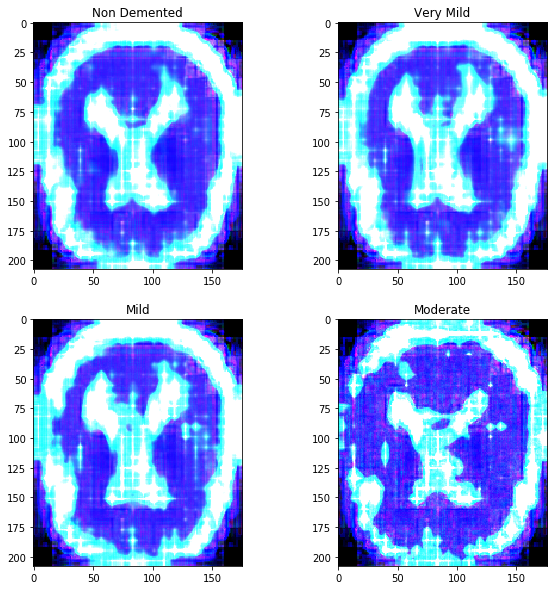

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plt.subplot(221)
plt.title('Non Demented')
plt.imshow(cv2.cvtColor(avg_non_dem, cv2.COLOR_BGR2RGB)); 

plt.subplot(222)
plt.title('Very Mild')
plt.imshow(cv2.cvtColor(avg_vmild_dem, cv2.COLOR_BGR2RGB)); 

plt.subplot(223)
plt.title('Mild')
plt.imshow(cv2.cvtColor(avg_mild_dem, cv2.COLOR_BGR2RGB)); 

plt.subplot(224)
plt.title('Moderate')
plt.imshow(cv2.cvtColor(avg_mod_dem, cv2.COLOR_BGR2RGB)); 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


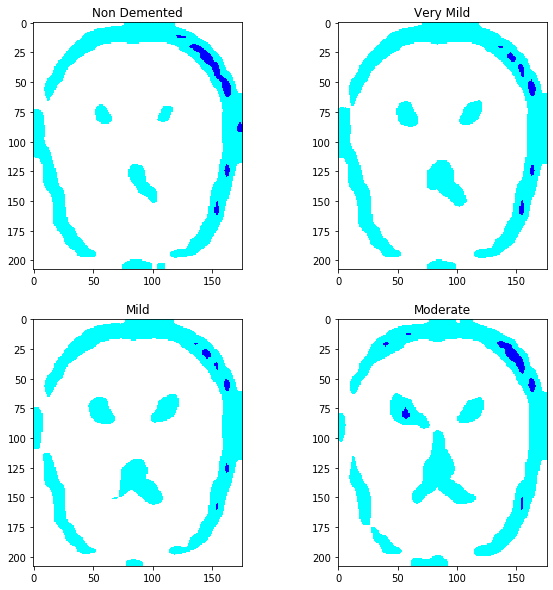

In [14]:
thresh_vals = np.linspace(1,255,255)
thresh_val = 100

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

plt.subplot(221)
plt.title('Non Demented')
ret,inverted_non = cv2.threshold(avg_non_dem,thresh_val,255,cv2.THRESH_BINARY_INV)
plt.imshow(inverted_non); 

plt.subplot(222)
plt.title('Very Mild')
ret,inverted_vmild = cv2.threshold(avg_vmild_dem,thresh_val,255,cv2.THRESH_BINARY_INV)
plt.imshow(inverted_vmild);

plt.subplot(223)
plt.title('Mild')
ret,inverted_mild = cv2.threshold(avg_mild_dem,thresh_val,255,cv2.THRESH_BINARY_INV)
plt.imshow(inverted_mild);

plt.subplot(224)
plt.title('Moderate')
ret,inverted_mod = cv2.threshold(avg_mod_dem,thresh_val,255,cv2.THRESH_BINARY_INV)
plt.imshow(inverted_mod);


